# **Bayesian Analysis of Golf** in memory of [Arnold Zellner](https://en.wikipedia.org/wiki/Arnold_Zellner)
___
Jupyter notebook for probabilistic predictions (scenario analysis) of choosing the best golf club on Par-3 Hole (inspired by [his 1999 Paper](https://ideas.repec.org/p/ags/ucbecw/198684.html))

Written by Victor Zommers | [Check out other notebooks](https://sites.google.com/view/victor-zommers/)

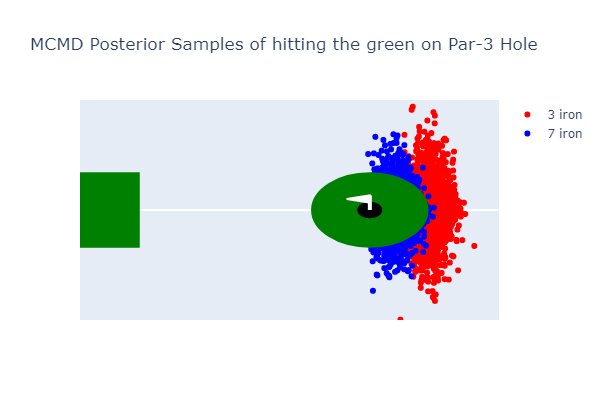

In [13]:
fig.show()

## **Index**
- Importing Packages
- Introduction to the Problem
- Model 1:
   - Probabilities & Utilities
- Model 2:
   - Markov Chain Monte Carlo (Green in Regualtion tee shot)
   - Logistic Link extension
   - 0-1 loss Function
   - Scatter Plot of sampled shots from the Priors

## **Importing Packages**

In [1]:
import numpy as np
from scipy.stats import norm

import arviz as az
import pymc as pm
import plotly.graph_objects as go

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## **Introduction from paper**
> The first problem the is choice between a 3-iron and a 7-iron for a tee shot on a Par-3 hole of length 200 yards with a green surrounded by water. A decision to use a 3-iron from the tee in an effort to hit the green may be successful. On the other hand, there is the possibility of ending up in the water with an associated penalty. 

> An alternative is to "play it safe" by laying up with the use of a 7-iron from the tee. After the lay up shot, it may be possible
to hit the green on the second shot and possibly get a moderately good score. Generally, the
decision to use a 3 or a 7-iron for the tee shot is made "heuristically" taking into account past
performance, current conditions, personal whims, objectives, etc. 

>To approach the problem more formally, consider Table 1 where the possible outcomes associated with the use of a 3 or of a-7
iron from the tee are delineated. The probabilities of specific outcomes, e.g. a score of 1 on the
hole are indicated by $p$'s and $q$'s. Note that in Table 1, we designate outcomes in terms of possible scores, namely 1,2, 3,..., 6
strokes. Here we are assuming that any outcome above a triple bogey, that is a 6, will be scored as 6. If desired, one could extend the range of outcomes beyond 6, but we shall not do so here. Second, the $p$'s and the $q$'s are probabilities associated with possible outcomes...

<table style="border: none;">
    <tr>
        <th colspan="8" style="border: none; text-align: center;">Table 1: Club Outcomes</th>
    </tr>
    <tr>
        <th style="border: none;"></th>
        <th colspan="6" style="border: none; text-align: center;">Outcomes</th>
        <th style="border: none; text-align: center;">Expected Scores & Utilities</th>
    </tr>
    <tr>
        <td style="border: none;"> </td>
        <td style="border: none; text-align: center;">1</td>
        <td style="border: none; text-align: center;">2</td>
        <td style="border: none; text-align: center;">3</td>
        <td style="border: none; text-align: center;">4</td>
        <td style="border: none; text-align: center;">5</td>
        <td style="border: none; text-align: center;">6*</td>
        <td style="border: none;"> </td>
    </tr>
    <tr>
        <td colspan="8" style="border: none;text-align: center;font-weight: bold;">3-iron</td>
    </tr>
    <tr>
        <td style="border: none;">Probabilities</td>
        <td style="border: none; text-align: center;">$p_1$</td>
        <td style="border: none; text-align: center;">$p_2$</td>
        <td style="border: none; text-align: center;">$p_3$</td>
        <td style="border: none; text-align: center;">$p_4$</td>
        <td style="border: none; text-align: center;">$p_5$</td>
        <td style="border: none; text-align: center;">$p_6$</td>
        <td style="border: none;">$ES_3=\sum_{i=1}^{6}p_ii$</td>
    </tr>
    <tr>
        <td style="border: none;">Utilities</td>
        <td style="border: none; text-align: left;">$U_3$(1)</td>
        <td style="border: none; text-align: left;">$U_3$(2)</td>
        <td style="border: none; text-align: left;">$U_3$(3)</td>
        <td style="border: none; text-align: left;">$U_3$(4)</td>
        <td style="border: none; text-align: left;">$U_3$(5)</td>
        <td style="border: none; text-align: left;">$U_3$(6)</td>
        <td style="border: none;">$EU_3=\sum_{i=1}^{6}p_iU_3(i)$</td>
    </tr>
    <tr>
        <td colspan="8" style="border: none;text-align: center;font-weight: bold;">7-iron</td>
    </tr>
    <tr>
        <td style="border: none;">Probabilities</td>
        <td style="border: none; text-align: center;">$q_1$</td>
        <td style="border: none; text-align: center;">$q_2$</td>
        <td style="border: none; text-align: center;">$q_3$</td>
        <td style="border: none; text-align: center;">$q_4$</td>
        <td style="border: none; text-align: center;">$q_5$</td>
        <td style="border: none; text-align: center;">$q_6$</td>
        <td style="border: none;">$ES_7=\sum_{i=1}^{6}q_ii$</td>
    </tr>
    <tr>
        <td style="border: none;">Utilities</td>
        <td style="border: none; text-align: left;">$U_7$(1)</td>
        <td style="border: none; text-align: left;">$U_7$(2)</td>
        <td style="border: none; text-align: left;">$U_7$(3)</td>
        <td style="border: none; text-align: left;">$U_7$(4)</td>
        <td style="border: none; text-align: left;">$U_7$(5)</td>
        <td style="border: none; text-align: left;">$U_7$(6)</td>
        <td style="border: none;">$EU_7=\sum_{i=1}^{6}q_iU_7(i)$</td>
    </tr>
</table>
*Any score higher than a triple bogey, i.e., a 6, is recorded as a 6.

## **Model 1**: Probabilities & Utilities
---

Define **Prior Probabilities & Utility values** (for scoring 1 to 6 using a 3-iron or 7-iron)

In [2]:
prior_probs_3_iron = np.array([0.05, 0.10, 0.20, 0.25, 0.20, 0.20])
prior_probs_7_iron = np.array([0.00, 0.05, 0.15, 0.30, 0.30, 0.20])

Add hypothetical data for **practice rounds (observations)**. Scores are represented as the number of occurrences (frequency table) of each score from 1 to 6 strokes.
Score of 1 will be a Hole-in-One.

In [3]:
data_3_iron = np.array([1, 2, 4, 3, 5, 5])
data_7_iron = np.array([0, 1, 3, 6, 5, 5])

**Update probabilities (Posterior)** based on data (assuming multinomial likelihood)

In [4]:
updated_probs_3_iron = (prior_probs_3_iron + data_3_iron) / (data_3_iron.sum() + 1)
updated_probs_7_iron = (prior_probs_7_iron + data_7_iron) / (data_7_iron.sum() + 1)

Now we will **define Utility function** for each score (i.e. inverse, Higher scores have lower utility) and calulcate **expected Utilities for each club**.

In [5]:
utilities = np.array([6, 5, 4, 3, 2, 1])
expected_utility_3_iron = np.dot(updated_probs_3_iron, utilities)
expected_utility_7_iron = np.dot(updated_probs_7_iron, utilities)

Now we will choose the club to maximise Utility

In [6]:
club_choice = "3-iron" if expected_utility_3_iron > expected_utility_7_iron else "7-iron"
print(f"Updated probabilities for 3-iron: {np.round(updated_probs_3_iron,2)}")
print(f"Updated probabilities for 7-iron: {np.round(updated_probs_7_iron,2)}")
print(f"Expected utility for 3-iron: {round(expected_utility_3_iron,2)}")
print(f"Expected utility for 7-iron: {round(expected_utility_7_iron,2)}")
print(f"Club choice based on expected utility: {club_choice}")

Updated probabilities for 3-iron: [0.05 0.1  0.2  0.15 0.25 0.25]
Updated probabilities for 7-iron: [0.   0.05 0.15 0.3  0.25 0.25]
Expected utility for 3-iron: 2.81
Expected utility for 7-iron: 2.5
Club choice based on expected utility: 3-iron


## **Markov chain Monte Carlo (MCMC)** 
---
Now, I will simplify the problem by just assuming that there is a friendly "swindle" being played for **hitting a Green In Regulation (GIR) with a single tee shot** or getting a Hole-in-One (statistically improbable so never bet if odds less than 1000:1).

### **Priors**
First, we will construct our Priors. We will use Beta distribution with shape parameters controlling Skewness and Kurtosis. This distribution is bounded between 0 and 1, so it is a natural choice for modelling Probabilities (or Limited Dependent Variables). <br>

Now we can adjust $\alpha$ and $\beta$ according to our Beliefs (or Handicap):
| Parameter Condition | Distribution Shape | Interpretation |
|-|-|-|
| α = β = 1           | Uniform            | All outcomes are equally possible |
| α > β               | Skewed towards 1   | More likely to hit GIR |
| α < β               | Skewed towards 0   | Less likely to hit GIR |
| α = β > 1           | Symmetric, peaks at 0.5 | Just as likely to hit GIR as to miss the Green|
| α = β < 1           | Symmetric, U-shaped | Either on Green or Air Shot/Topping, no in-between|


### **Observed Data** (Practice Rounds)
Since every Practice round is Independent & Identical (IID), we can use Binomial Distribution to express our likelihood.

In [7]:
# Hypothetical data: successes and trials for 3-iron and 7-iron on Par-3
# For this example, a success will mean hitting the green in regualtion (GIR)
data_3_iron_successes = 50
data_3_iron_trials = 100
data_7_iron_successes = 65
data_7_iron_trials = 100

### **Likelihood & Posterior Sampling**

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_3_iron, p_7_iron]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


array([[<Axes: title={'center': 'p_3_iron'}>,
        <Axes: title={'center': 'p_3_iron'}>],
       [<Axes: title={'center': 'p_7_iron'}>,
        <Axes: title={'center': 'p_7_iron'}>]], dtype=object)

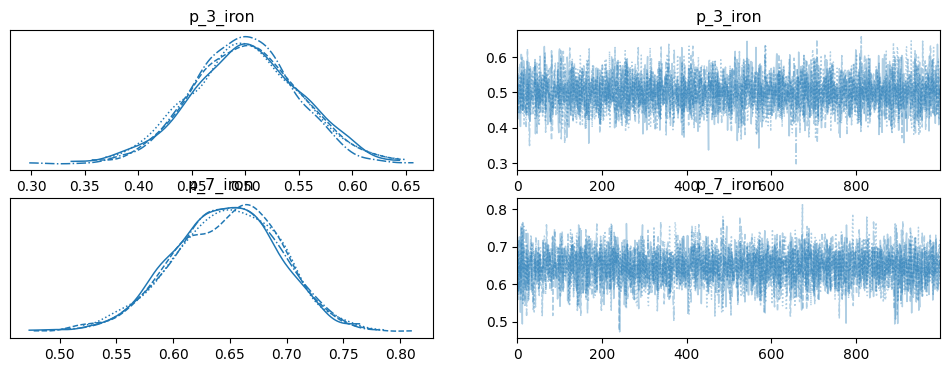

In [8]:
with pm.Model() as model:
    # Prior probabilities for each club
    p_3_iron = pm.Beta('p_3_iron', alpha=1, beta=1)
    p_7_iron = pm.Beta('p_7_iron', alpha=1, beta=1)
    
    # Binomial likelihoods from observed data
    obs_3_iron = pm.Binomial('obs_3_iron', n=data_3_iron_trials, p=p_3_iron, observed=data_3_iron_successes)
    obs_7_iron = pm.Binomial('obs_7_iron', n=data_7_iron_trials, p=p_7_iron, observed=data_7_iron_successes)
    
    # We can use Metropolis-Hastings for sampling:
    # step = pm.Metropolis()
    # trace = pm.sample(10000, step=step)
    # or MCMC sampling using Hamiltonian Monte Carlo to avoid random walk:
    trace1 = pm.sample(draws=1000, progressbar=True)

az.plot_trace(trace1, var_names=['p_3_iron', 'p_7_iron'])

### **Logistic Link function** to update Probabilities
We use Bernoulli Distribution to represent probability of success in a single trial (success from one shot only). We are also able to introduce more regression parameters, like "distance to the hole" (or Weather) to gather more information from our attempts. 

c:\Users\victo\OneDrive\Desktop\BayesianGolf\.conda\Lib\site-packages\pymc\data.py:434: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_distance, beta_club]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 27 seconds.


array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'beta_distance'}>,
        <Axes: title={'center': 'beta_distance'}>],
       [<Axes: title={'center': 'beta_club'}>,
        <Axes: title={'center': 'beta_club'}>]], dtype=object)

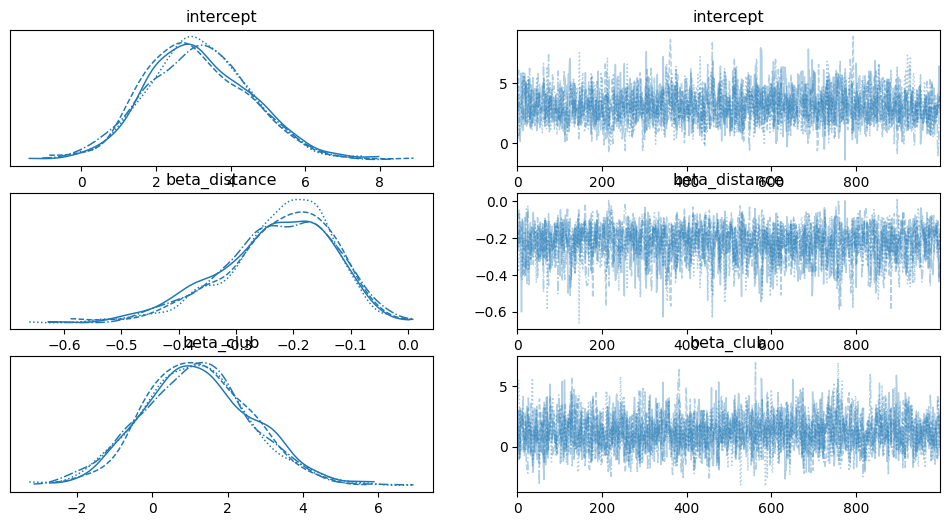

In [9]:
with pm.Model() as model:
    # Regression coefficients, we use mean and sd to express our Prior beliefs. Note that coeffs are not easily interpretable. 
    intercept = pm.Normal('intercept', mu=0, sigma=2)
    beta_distance = pm.Normal('beta_distance', mu=0, sigma=2)
    beta_club = pm.Normal('beta_club', mu=0, sigma=2)

    # Observed data (theano tensors as pymc4)
    distance_to_hole = pm.Data('distance_to_hole', np.array([40, 20, 5, 10, 50, 30, 15, 7, 40, 10]))
    # 1 for 3-iron, 0 for 7-iron
    club_choice = pm.Data('club_choice', np.array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0]))
    # 1 for Green in Regulation (GIR), 0 for miss
    success = np.array([0, 0, 1, 1, 0, 0, 1, 1, 0, 1])

    # Logistic link func
    logit_p = intercept + beta_distance * distance_to_hole + beta_club * club_choice
    # Likelihood func
    observed = pm.Bernoulli('observed', logit_p=logit_p, observed=success)

    # Sampling from Posterior
    # We can use Metropolis-Hastings for sampling:
    # step = pm.Metropolis()
    # trace = pm.sample(10000, step=step)
    trace2 = pm.sample(draws=1000, tune=500, target_accept=0.95)
az.plot_trace(trace2)

### **0-1 Loss function**
This is a parsimonious method to measure accuracy of our logistic classifier (& estimated cost to our Utility from wrong predictions). 
For each prediction:
- If the model predicts the correct class, the loss is 0. 
- If the model predicts the wrong class, the loss is 1.

The mean 0-1 loss is the average of these losses for all predictions. 
In our case, a mean 0-1 loss of 0.07 means that models predictions can be accurate 93% of the time.

In [10]:
def zero_one_loss(y_true, y_pred):
    return np.where(y_true == y_pred, 0, 1)

with model:
    # Take posterior from logistic link
    ppc = pm.sample_posterior_predictive(trace2)
    # Predict 1 if mean >= 0.5, else 0
    y_pred = (ppc['posterior_predictive']['observed'].mean(axis=0) >= 0.5).astype(int)
    # Calculate 0-1 loss
    loss = zero_one_loss(success, y_pred)
# Return average 
print(f"0-1 loss: {loss.mean()}")

Sampling: [observed]


0-1 loss: 0.0734


## **Scatter Plot of Golf Shots (from the first MCMD model)**

Now 2 caveats which we didn't model:
- Shots from the same distribution can be both Short & Long of the Green
- Ideally, there should be 2 distributions for every Club: Distance (X-axis), Slice/Shank (Y-axis)<br>

Since we only have 1 distribution per club, I will just introduce some heuristic variance noise for Slice/Shank.
We also inverse the X-axis, so lower probabilities represent going long/over the Green.

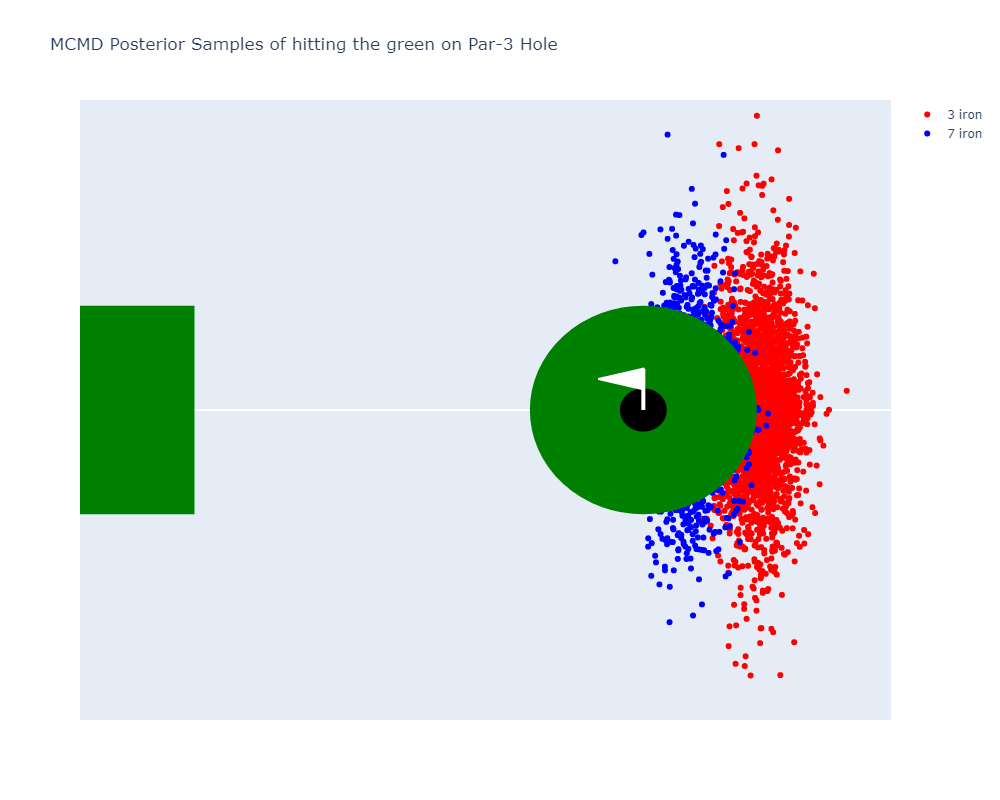

In [14]:
p_3_iron_samples = trace1.posterior['p_3_iron'].values.flatten()
p_7_iron_samples = trace1.posterior['p_7_iron'].values.flatten()

# hardcode variance to y values
p_7_iron_variance = np.random.normal(0, np.linspace(0.00, 0.4, len(p_7_iron_samples)))
p_3_iron_variance = np.random.normal(0, np.linspace(0.01, 0.5, len(p_3_iron_samples)))

fig = go.Figure()
# tee box
fig.add_shape(type="rect",
    x0=2, y0=-0.5, x1=1.75, y1=0.5,
    line=dict(color="Green"),
    fillcolor="Green"
)
# green
fig.add_shape(type="circle",
    x0=0.5, y0=-0.5, x1=1, y1=0.5,
    line=dict(color="Green"),
    fillcolor="Green"
)
# hole
fig.add_shape(type="circle",
    x0=0.7, y0=-0.10, x1=0.8, y1=0.10,
    line=dict(color="Black"),
    fillcolor="Black"
)
# flag
fig.add_shape(type="path",
    path="M 0.75 0.2 L 0.85 0.15 L 0.75 0.1 Z",
    line=dict(color="White"),
    fillcolor="White"
)
fig.add_shape(type="line",
    x0=0.75, y0=0, x1=0.75, y1=0.2,
    line=dict(color="white", width=4)
)
fig.add_trace(go.Scatter(
    x=p_3_iron_samples,
    y=p_3_iron_variance,
    mode='markers',
    name='3 iron',
    marker=dict(color='red')
))
fig.add_trace(go.Scatter(
    x=p_7_iron_samples,
    y=p_7_iron_variance,
    mode='markers',
    name='7 iron',
    marker=dict(color='blue') 
))

fig.update_xaxes(range=[-1, 4], showgrid=False)
fig.update_yaxes(range=[-1.5, 1.5], showgrid=False)
fig.update_layout(width=1000, height=800,
    title='MCMD Posterior Samples of hitting the green on Par-3 Hole',
    xaxis_autorange='reversed',
    showlegend=True,
    xaxis=dict(showticklabels=False),
    yaxis=dict(showticklabels=False),
)

fig.show()

Just a quick hack to render plotly as png for github repo:

In [11]:
import plotly.io as pio
pio.renderers.default = "png"